# REIT

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [78]:
ticker_list = ['BBRE', 'IFGL']
tiskers = yf.Tickers(' '.join(ticker_list))
historical_data = tiskers.history(period='max')
df = pl.DataFrame({
    "Date": historical_data.index,
    "BBRE": historical_data['Close']['BBRE'],
    "IFGL": historical_data['Close']['IFGL'],
    "BBRE_dividends": historical_data['Dividends']['BBRE'] / historical_data['Close']['BBRE'],
    "IFGL_dividends": historical_data['Dividends']['IFGL'] / historical_data['Close']['IFGL'],
})

[*********************100%***********************]  2 of 2 completed


In [79]:
df = df.drop_nulls(subset=["BBRE"]).with_columns([
    pl.col("BBRE").log().alias("BBRE_log"),
    pl.col("IFGL").log().alias("IFGL_log")
]).with_columns([
    pl.col("BBRE_log").diff().fill_null(value=0).alias("BBRE_log_diff"),
    pl.col("IFGL_log").diff().fill_null(value=0).alias("IFGL_log_diff"),
]).with_columns([
    (pl.col("BBRE_log_diff") + pl.col("BBRE_dividends")).cum_sum().alias("BBRE_log_cumsum"),
    (pl.col("IFGL_log_diff") + pl.col("IFGL_dividends")).cum_sum().alias("IFGL_log_cumsum"),
]).with_columns([
    ((pl.col("BBRE_log_cumsum").exp() - 1)*100).alias("BBRE_return"),
    ((pl.col("IFGL_log_cumsum").exp() - 1)*100).alias("IFGL_return"),
])

Text(0, 0.5, '累積リターン (%)')

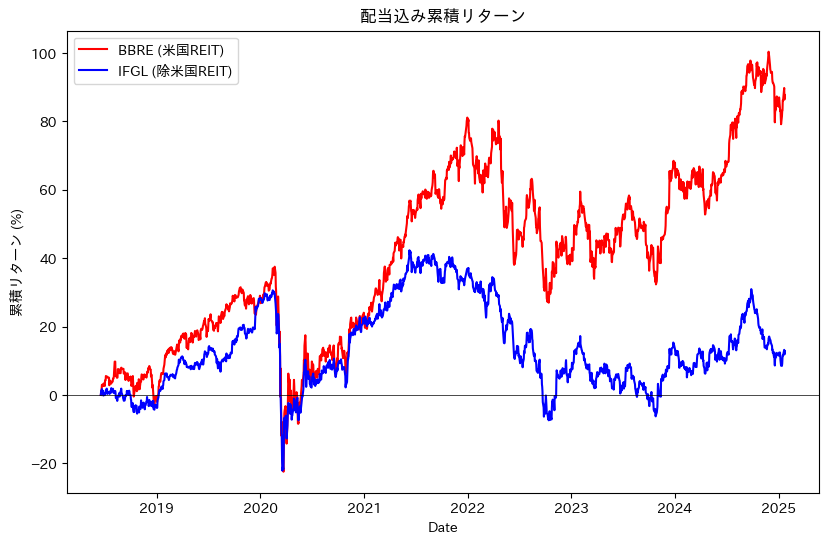

In [86]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
sns.lineplot(data=df.to_pandas(), x='Date', y='BBRE_return', ax=ax, label='BBRE (米国REIT)', color='red')
sns.lineplot(data=df.to_pandas(), x='Date', y='IFGL_return', ax=ax, label='IFGL (除米国REIT)', color='blue')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title("配当込み累積リターン")
ax.set_ylabel('累積リターン (%)')

In [91]:
volatility_df = df.select([
    pl.col("Date"),
    pl.col("BBRE_log_diff"),
    pl.col("IFGL_log_diff"),
])

In [93]:
volatility_df.std()

Date,BBRE_log_diff,IFGL_log_diff
datetime[ns],f64,f64
null,0.015049,0.011478
